# Linear Regression with PyTorch: Datasets, Models, and Losses 
Author: Pierre Nugues

## Dataset

We extract the counts of letters per chapter and the counts of _A_ from the *Salammbô* novel by Flaubert. There are 15 chapters in total.

In [1]:
import torch
from torch import nn
from torch import optim
import random
import matplotlib.pyplot as plt
import tqdm
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

In [2]:
random.seed(4321)
torch.manual_seed(4321)

The $X$ matrix

In [3]:
X = torch.Tensor(
    [[36961],
     [43621],
     [15694],
     [36231],
     [29945],
     [40588],
     [75255],
     [37709],
     [30899],
     [25486],
     [37497],
     [40398],
     [74105],
     [76725],
     [18317]])

In the mean squared error loss function (MSE), $y$ must have the same shape as the input. See here: `https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html`. We reshape it so that it becomes a column vector.

In [4]:
y = torch.Tensor(
    [2503, 2992, 1042, 2487, 2014, 2805, 5062, 2643, 2126, 1784, 2641, 2766,
     5047, 5312, 1215]).reshape((-1, 1))
y

tensor([[2503.],
        [2992.],
        [1042.],
        [2487.],
        [2014.],
        [2805.],
        [5062.],
        [2643.],
        [2126.],
        [1784.],
        [2641.],
        [2766.],
        [5047.],
        [5312.],
        [1215.]])

## Visualizing the Dataset

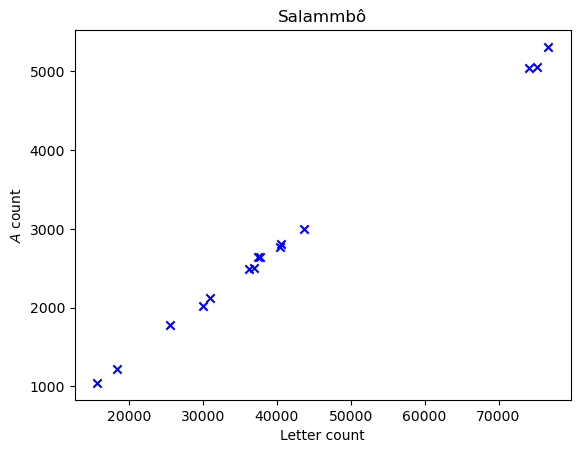

In [5]:
fr = plt.scatter(X, y, c='b', marker='x')
plt.title("Salammbô")
plt.xlabel("Letter count")
plt.ylabel("$A$ count")
plt.show()

## Linear Regression with PyTorch

We create the architecture. The model has an intercept (a bias) by default.

In [6]:
model = nn.Sequential(nn.Linear(1, 1))
model

Sequential(
  (0): Linear(in_features=1, out_features=1, bias=True)
)

In [7]:
model[0].weight, model[0].bias

(Parameter containing:
 tensor([[-0.7489]], requires_grad=True),
 Parameter containing:
 tensor([0.0753], requires_grad=True))

We use the mean squared error and nadam, a variant of stochastic gradient descent, to find the parameters

In [8]:
list(model.parameters())

[Parameter containing:
 tensor([[-0.7489]], requires_grad=True),
 Parameter containing:
 tensor([0.0753], requires_grad=True)]

In [9]:
loss_fn = nn.MSELoss()
optimizer = optim.NAdam(model.parameters(), lr=0.01)

## Batch descent

We fit the two parameters with the whole dataset

In [10]:
loss_fn

MSELoss()

In [11]:
optimizer

NAdam (
Parameter Group 0
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: False
    differentiable: False
    eps: 1e-08
    foreach: None
    lr: 0.01
    maximize: False
    momentum_decay: 0.004
    weight_decay: 0
)

In [12]:
model

Sequential(
  (0): Linear(in_features=1, out_features=1, bias=True)
)

In [13]:
loss_history = []
model_x = []
model_y = []
model.train()
for epoch in range(250):
    sse = 0
    y_pred = model(X)                       # We compute Xw = y_hat
    loss = loss_fn(y_pred, y)               # (h_hat - y)^2
    sse += loss.item()
    model_x += [model[0].weight.item()]
    model_y += [model[0].bias.item()]
    loss_history += [sse]
    optimizer.zero_grad()
    loss.backward()                         # we compute the gradients ∇ (h_hat - y)^2
    optimizer.step()                        # we update the weights -⍺ ∇ (h_hat - y)^2

In [14]:
model[0].weight, model[0].bias

(Parameter containing:
 tensor([[0.0676]], requires_grad=True),
 Parameter containing:
 tensor([0.8920], requires_grad=True))

In [15]:
model.eval()

Sequential(
  (0): Linear(in_features=1, out_features=1, bias=True)
)

Predict the values with the model: $model(X_{\text{test}})$

In [ ]:
X_test = torch.FloatTensor([[3000],
                            [5000]])

In [17]:
with torch.no_grad():
    print(model(X_test))

tensor([[203.5815],
        [338.7079]])


Predict one input `X_test[0]` with the parameters: $w_1 x + w_0$

In [18]:
with torch.no_grad():
    print(model[0].weight @ X_test[0] +
          model[0].bias)

tensor([203.5815])


Predict a dataset: $XW^\intercal + w_0$

In [19]:
with torch.no_grad():
    print(X_test @ model[0].weight.T +
          model[0].bias)

tensor([[203.5815],
        [338.7079]])


### The Model History

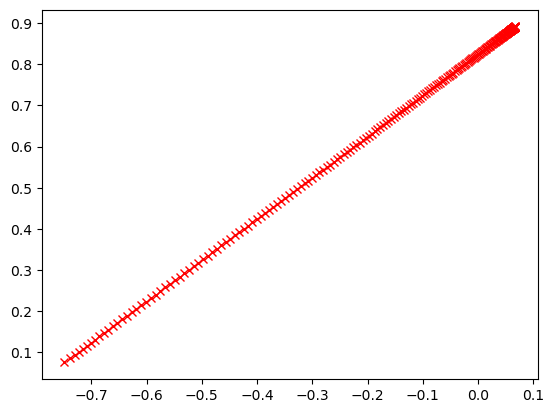

In [20]:
plt.plot(model_x, model_y, 'rx')

### The Loss History

In [21]:
loss_history[-1]

3708.039794921875

Last loss after last update

In [22]:
with torch.no_grad():
    last_loss = (model(X) - y).T @ (model(X) - y)/15
last_loss.item()

3551.81103515625

### Visualising the Loss
We visualise the loss during the training process

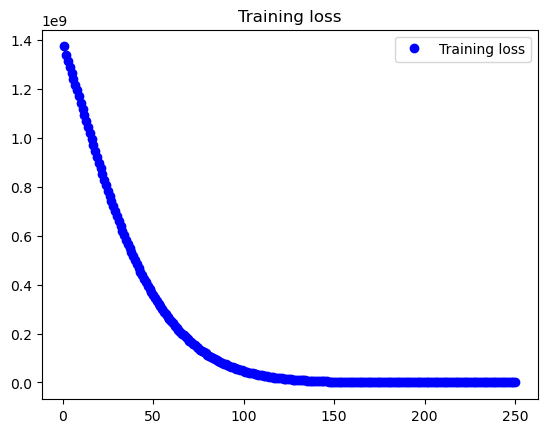

In [23]:
epochs = range(1, len(loss_history) + 1)
plt.plot(epochs, loss_history, 'bo', label='Training loss')
plt.title('Training loss')
plt.legend()
plt.show()

### Visualization of the model on the loss surface

In [24]:
def mean_squared_errors(X: torch.tensor, y: torch.tensor, w: torch.tensor) -> torch.tensor:
    """
    Sum of the squared errors:
    Prediction: Xw = ŷ
    Error (loss): (y - ŷ)^2
    :param X: The input matrix: The predictors
    :param y: The output vector: The response
    :param w: The weight vector: The model
    :return: The error
    """
    v = y.reshape(-1,) - (X @ w)
    return (v @ v)/X.size()[0]

In [25]:
def compute_3d_matrices(X: torch.tensor, y: torch.tensor):
    """
    Compute the 3D matrix of errors
    Axes x and y, the weights
    Axis z the error
    :param X:
    :param y:
    :return:
    """

    w0_range = np.linspace(-1000, 1000, 100)
    w1_range = np.linspace(0, 0.15, 100)
    x_axis, y_axis = np.meshgrid(w0_range, w1_range)
    z_axis = np.array([mean_squared_errors(X, y, np.array([w0, w1]))
                       for w0 in w0_range for w1 in w1_range])
    z_axis = np.log10(z_axis)
    z_axis = z_axis.reshape(x_axis.shape)
    return x_axis, y_axis, z_axis

In [26]:
def plot(fig, ax, X, y, color):
    X, Y, Z = compute_3d_matrices(X, y)
    # ax.view_init(azim=210)
    surf = ax.plot_surface(Y, X, Z, rstride=1, cstride=1, cmap=color,
                           linewidth=0, antialiased=False)
    fig.colorbar(surf, shrink=0.5, aspect=5)

In [27]:
# X_hom = torch.hstack((torch.ones((len(y), 1)), X))

In [28]:
def plot_descent(X_hom: torch.tensor, y: torch.tensor,
                 model_x: list[float], model_y: list[float], loss_history: list[float]):
    fig = plt.figure()
    ax = Axes3D(fig, auto_add_to_figure=False)
    fig.add_axes(ax)

    plot(fig, ax, X_hom, y, plt.cm.coolwarm)
    ax.scatter(model_x, model_y, np.log10(
        np.array(loss_history)), c='red', marker='*')

    plt.show()

In [29]:
model_x[-1], model_y[-1], loss_history[-1]

(0.06752170622348785, 0.8919243812561035, 3708.039794921875)

In [30]:
def plot_loss_from_coords(X: torch.tensor,
                          y: torch.tensor,
                          model_x: list[float],
                          model_y: list[float]):
    # We need homogeneous coordinates
    with torch.no_grad():
        X_hom = torch.hstack((torch.ones((len(y), 1)), X))
        loss_history_exact = [mean_squared_errors(X_hom, y,
                                                  torch.tensor([w0, w1])).item()
                              for w0, w1 in zip(model_y, model_x)]
        plot_descent(X_hom, y, model_x, model_y, loss_history_exact)

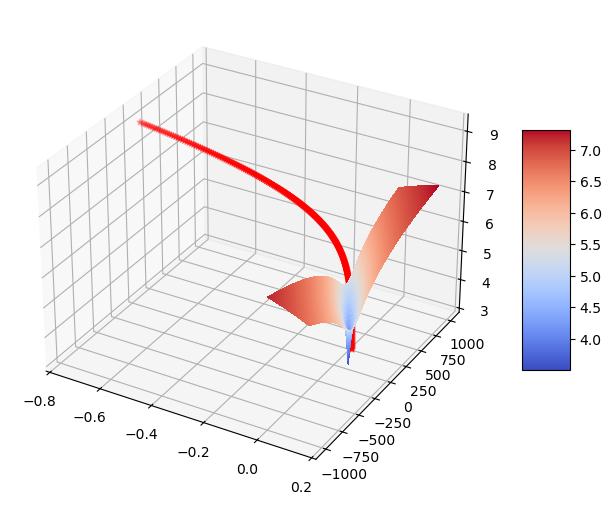

In [31]:
plot_loss_from_coords(X, y, model_x, model_y)

## Stochastic descent
Each observation will lead to an update

We reset the model

In [32]:
model[0].reset_parameters()

In [33]:
loss_history = []
model_x = []
model_y = []
model.train()
for epoch in range(20):
    sse = 0
    for xi, yi in zip(X, y):
        yi_pred = model(xi)
        loss = loss_fn(yi_pred, yi)
        sse += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_history += [sse/X.size()[0]]
    model_x += [model[0].weight.item()]
    model_y += [model[0].bias.item()]

In [34]:
model[0].weight, model[0].bias

(Parameter containing:
 tensor([[0.0685]], requires_grad=True),
 Parameter containing:
 tensor([-1.1780], requires_grad=True))

### Visualising the Loss
We visualise the loss during the training process

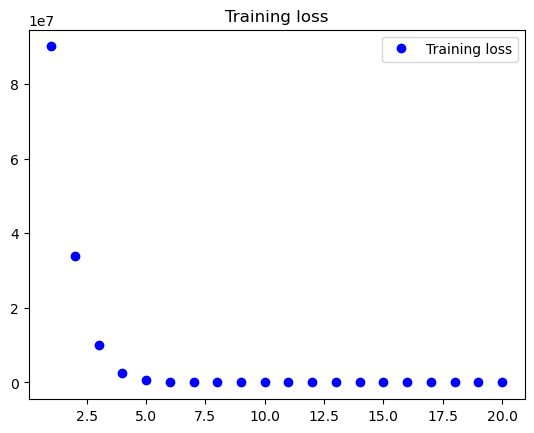

In [35]:
epochs = range(1, len(loss_history) + 1)
plt.plot(epochs, loss_history, 'bo', label='Training loss')
plt.title('Training loss')
plt.legend()
plt.show()

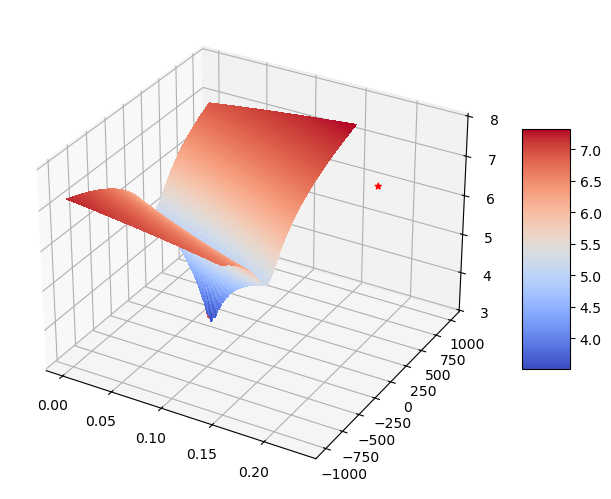

In [36]:
plot_loss_from_coords(X, y, model_x, model_y)

## Mini-batch gradient descent

In [37]:
BATCH_SIZE = 4

In [43]:
model[0].reset_parameters()

In [44]:
loss_history = []
model_x = []
model_y = []
model.train()
for epoch in range(40):
    sse = 0
    for i in range(X.size()[0]//BATCH_SIZE):
        Xi = X[i:i+BATCH_SIZE]
        yi = y[i:i+BATCH_SIZE]
        yi_pred = model(Xi)
        loss = loss_fn(yi_pred, yi)
        sse += loss.item() * Xi.size()[0]
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_history += [sse/X.size()[0]]
    model_x += [model[0].weight.item()]
    model_y += [model[0].bias.item()]

In [45]:
model[0].weight, model[0].bias

(Parameter containing:
 tensor([[0.0649]], requires_grad=True),
 Parameter containing:
 tensor([1.5302], requires_grad=True))

### Loss History

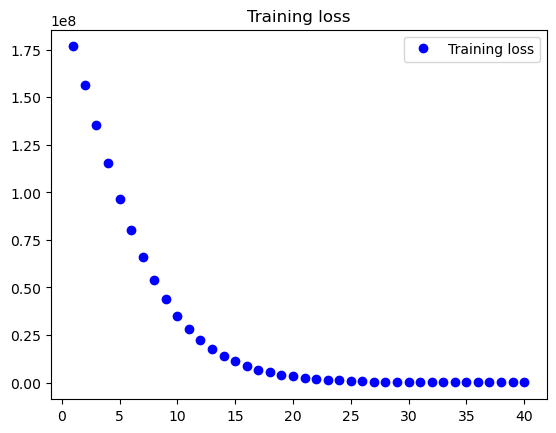

In [46]:
epochs = range(1, len(loss_history) + 1)
plt.plot(epochs, loss_history, 'bo', label='Training loss')
plt.title('Training loss')
plt.legend()
plt.show()

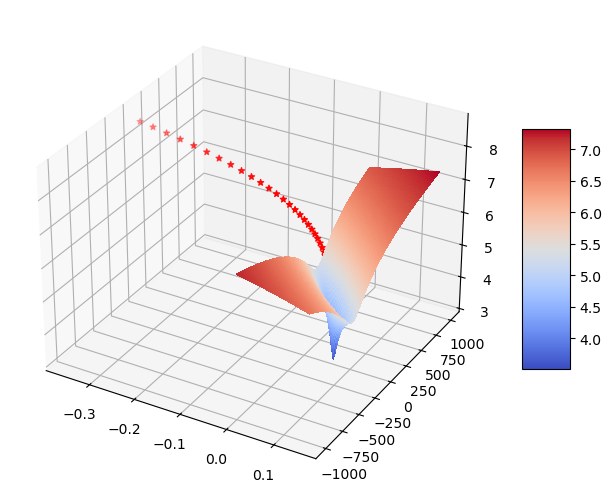

In [47]:
plot_loss_from_coords(X, y, model_x, model_y)

## With a Dataloader

In [48]:
from torch.utils.data import TensorDataset, DataLoader

dataset = TensorDataset(X, y)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

In [49]:
model[0].reset_parameters()

In [50]:
loss_history = []
model_x = []
model_y = []
model.train()
for epoch in range(100):
    sse = 0
    for X_batch, y_batch in dataloader:
        y_batch_pred = model(X_batch)
        loss = loss_fn(y_batch_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        sse += loss.item() * X_batch.size()[0]
    loss_history += [sse/X.size()[0]]
    model_x += [model[0].weight.item()]
    model_y += [model[0].bias.item()]

In [51]:
model[0].weight, model[0].bias

(Parameter containing:
 tensor([[0.0685]], requires_grad=True),
 Parameter containing:
 tensor([-0.2117], requires_grad=True))

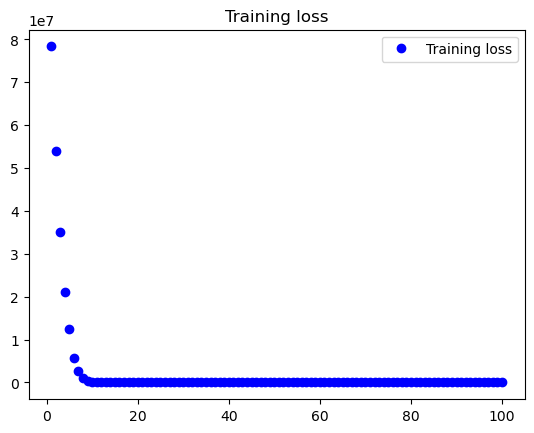

In [52]:
epochs = range(1, len(loss_history) + 1)
plt.plot(epochs, loss_history, 'bo', label='Training loss')
plt.title('Training loss')
plt.legend()
plt.show()

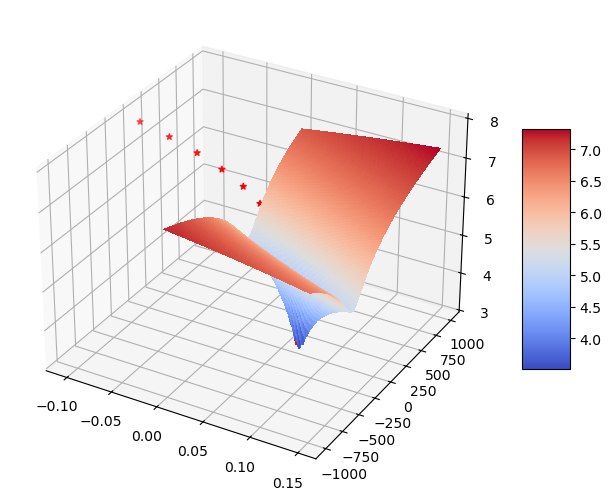

In [53]:
plot_loss_from_coords(X, y, model_x, model_y)

## Visualizing the Final Model

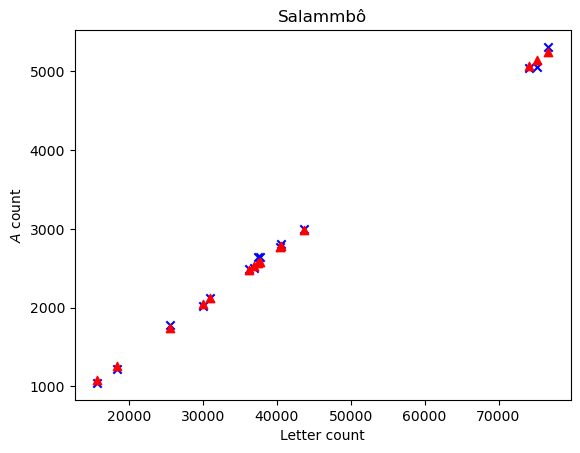

In [54]:
fr = plt.scatter(X, y, c='b', marker='x')
plt.scatter(X, model(X).detach().numpy(), color='red', marker='^')
plt.title("Salammbô")
plt.xlabel("Letter count")
plt.ylabel("$A$ count")
plt.show()

## Gradients
PyTorch computes automatically the gradients. See https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html. Here we will compute them manually and check the PyTorch's values

We fit the model again

In [55]:
model[0].reset_parameters()

In [56]:
loss_history = []
model.train()
for epoch in range(250):
    sse = 0
    y_pred = model(X)
    loss = loss_fn(y_pred, y)
    sse += loss.item()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_history += [sse]

We apply it to the dataset and we compute the loss

In [57]:
model.eval()
y_pred = model(X)
y_pred

tensor([[2531.2471],
        [2987.1624],
        [1075.3984],
        [2481.2744],
        [2050.9617],
        [2779.5361],
        [5152.6914],
        [2582.4521],
        [2116.2683],
        [1745.7172],
        [2567.9395],
        [2766.5295],
        [5073.9673],
        [5253.3218],
        [1254.9579]], grad_fn=<AddmmBackward0>)

The loss according to PyTorch

In [58]:
loss = loss_fn(y_pred, y)
loss

tensor(1902.6993, grad_fn=<MseLossBackward0>)

we check the loss manually

In [59]:
1/X.size()[0] * (y_pred - y).T @ (y_pred - y)

tensor([[1902.6995]], grad_fn=<MmBackward0>)

We compute the gradients manually:
$$
\begin{array}{lclcl}
\displaystyle{\frac{\partial{Loss}}{\partial{m}}} &=& \displaystyle{\sum_{i = 1}^{q}{\frac{\partial{}}{\partial{m}}(y_i - (mx_i + b))^2}} &=& \displaystyle{-2\sum_{i = 1}^{q}{x_i(y_i - (mx_i + b))}} \\
\displaystyle{\frac{\partial{Loss}}{\partial{b}}} &=& \displaystyle{\sum_{i = 1}^{q}{\frac{\partial{}}{\partial{b}}(y_i - (mx_i + b))^2}} &=& \displaystyle{-2 \sum_{i = 1}^{q}{(y_i - (mx_i + b))}}
\end{array}
$$
$m$ is the weight and $b$ is the bias. By default, PyTorch computes the gradient mean of a batch

The gradient according to our equations

In [60]:
-2/X.size()[0] * (y - y_pred).T @ X, -2/X.size()[0] * torch.sum(y - y_pred)

(tensor([[-200.1250]], grad_fn=<MmBackward0>),
 tensor(-2.6100, grad_fn=<MulBackward0>))

### PyTorch's gradients
The gradients are accumulated, we need to clear them before we apply `backward()` to compute them

In [61]:
optimizer.zero_grad()
loss.backward()

The gradient according to PyTorch

In [62]:
model[0].weight.grad, model[0].bias.grad

(tensor([[-200.1250]]), tensor([-2.6100]))